<a href="https://colab.research.google.com/github/astrfo/RS_init/blob/main/RS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# RS 実装

[満足化を通じた最適な自律的探索] https://www.jstage.jst.go.jp/article/pjsai/JSAI2018/0/JSAI2018_1Z304/_article/-char/ja/

[論文要約] https://github.com/astrfo/AutonomousOptimalExplorationThroughSatisficing/blob/main/AutonomousOptimalExplorationThroughSatisficing.ipynb




In [18]:
import sys
import numpy as np
import random
import matplotlib.pyplot as plt
import time
%matplotlib inline

In [19]:
class Environment(object):
    """
    K本の各腕の確率を生成
    当たりかハズレかを返す
    """

    def __init__(self, K):
        self._K = K
        self.prob = np.array([np.random.rand() for _ in range(K)])
        # print(f'prob: {self.prob}')
        # print(f'OPT: {sum(self.prob) / K}')

    def play(self, arm):
        if self.prob[arm] > np.random.rand():
            return 1
        else:
            return 0

In [20]:
class Policy(object):
    """
    各方策の実行
    """

    def __init__(self, policy):
        if 'RS-CH' == policy:
            self.act_policy = self.RSFunc
        if 'RS-OPT' == policy:
            self.act_policy = self.RS_OPT
        if 'e-greedy' == policy:
            self._epsilon = 0.1
            self.act_policy = self.e_greedy
        if 'random' == policy:
            self.act_policy = self.random_
        if 'ThompsonSampling' == policy:
            self.act_policy = self.ThompsonSampling


    def RSFunc(self, _, RS):
        return np.argmax(RS)

    def RS_OPT(self, _, RS):
        return np.argmax(RS)

    def e_greedy(self, V, _):
        if self._epsilon < np.random.rand():
            return np.random.choice(np.where(V == V.max())[0])
        else:
            return np.random.randint(len(V))

    def random_(self, V, _):
        return np.random.randint(len(V))

    # def ThompsonSampling(self, V, _):
    #     return 1

In [21]:
class RSAgent(object):
    """
    経験期待値の更新
    RS価値関数の定義、更新
    基準値alephの更新, KL情報量
    RS-greedy選択肢を試行する
    """

    def __init__(self, K, policy):
        self._K = K
        self._alpha = None
        self._V = None
        self._n = None
        self._N = None
        self.RS = None
        self.aleph = None
        self.aleph_opt = None
        self._mu = None
        self._policy = Policy(policy)

    def initialize(self):
        self._V = np.array([0.5] * self._K)
        self._n = np.array([1e-8] * self._K)
        self._N = 0
        self.RS = np.zeros(self._K)
        self.aleph = 1.0

    def update(self, arm, reward):
        self._alpha = 1 / (1 + self._n[arm])
        self._V[arm] = (1 - self._alpha) * self._V[arm] + (reward * self._alpha)
        self._n[arm] += 1
        self._N += 1
        self.RS = (self._n / self._N) * (self._V - self.aleph)

    def update_aleph(self):
        G = random.choice(np.where(self._V == self._V.max())[0])
        self._mu = np.exp(-self._n * self.D_KL(self._V, self._V[G]))
        print(self._mu)
        aleph_list = self._V[G] * (1 - (self._V/self._V[G]) * self._mu) / (1 - self._mu)
        np.nan_to_num(aleph_list, copy=False)
        self.aleph = max(aleph_list)

    def D_KL(self, p, q):
        return p*np.log(p/q) + (1-p)*np.log( (1-p) / (1-q) )

    def select_arm(self):
        return self._policy.act_policy(self._V, self.RS)

In [22]:
class Simulator(object):
    """
    シミュレーションを行う
    regretの計算
    regret,stepsをplot
    """
    
    def __init__(self, trial, step, K):
        self._algorithm = ["RS-CH", "RS-OPT"]
        self._env = None
        self._prob = None
        self._trial = trial
        self._step = step
        self._K = K
        self._regret = np.zeros(step)
        self._regretV = None
        self.fig, self.ax = plt.subplots()

    def run(self):
        for algo in self._algorithm:
            self._agent = RSAgent(self._K, algo)
            print(f'algorithm: {algo}')
            for t in range(self._trial):
                self._env = Environment(self._K)
                self._prob = self._env.prob
                self._agent.initialize()
                self._regretV = 0.0
                for s in range(self._step):
                    arm = self._agent.select_arm()
                    reward = self._env.play(arm)
                    self._agent.update(arm, reward)
                    self.calc_regret(t, s, arm)
                    if algo == "RS-CH": self._agent.update_aleph()
                    if algo == "RS-OPT": self._agent.aleph = sum(self._prob) / self._K
            self.print_regret()
        self.fig.tight_layout()
        plt.show()

    def calc_regret(self, t, s, arm):
        self._regretV += (self._prob.max() - self._prob[arm])
        self._regret[s] += (self._regretV - self._regret[s]) / (t+1)

    def print_regret(self):
        self.ax.plot(np.arange(self._step), self._regret, linestyle='dashed')
        self.ax.set_title(f'sim: {self._trial}, step: {self._step}, K: {self._K}')
        self.ax.set_xlabel("steps")
        self.ax.set_ylabel("regret")
        self.ax.legend(labels=self._algorithm)

algorithm: RS-CH
prob: [0.28342026 0.44780498]
OPT: 0.36561262114965215
[0.50000005 1.        ]
[4.99999999e-09 1.00000000e+00]
[0.50000005 1.        ]
[1. 1.]
[0.84375 1.     ]
[0.59259259 1.        ]
[0.93644262 1.        ]
[0.59259259 1.        ]
[0.36408889 1.        ]
[0.59259259 1.        ]
[0.42648896 1.        ]
[0.3125 1.    ]
[0.23411065 1.        ]
[0.1792 1.    ]
[0.13988116 1.        ]
[0.23411065 1.        ]
[0.33197302 1.        ]
[0.16438542 1.        ]
[0.23532327 1.        ]
[0.1875 1.    ]
[0.15087426 1.        ]
[0.12256406 1.        ]
[0.17062096 1.        ]
[0.22212359 1.        ]
[0.27531052 1.        ]
[0.15152446 1.        ]
[0.19148484 1.        ]
[0.23328 1.     ]
[0.27605104 1.        ]
[0.17028018 1.        ]
[0.20433976 1.        ]
[0.16750975 1.        ]
[0.19857053 1.        ]
[0.23065413 1.        ]
[0.1937151 1.       ]
[0.2231804 1.       ]
[0.18957363 1.        ]
[0.2168046 1.       ]
[0.13721783 1.        ]
[0.1588069 1.       ]
[0.18126975 1.      

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


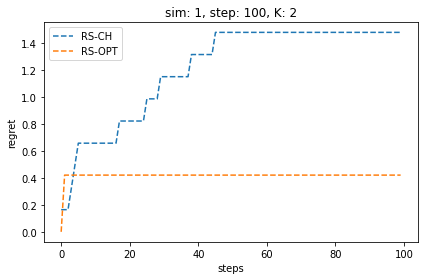

elapsed_time:0.3289070129394531[sec]


In [23]:
def main():
    trial = 1
    step = 100
    K = 2
    sim = Simulator(trial, step, K)
    sim.run()




start = time.time()
main()
elapsed_time = time.time() - start
print("elapsed_time:{0}".format(elapsed_time) + "[sec]")